In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
cwd = os.getcwd()

api_path = os.path.join(cwd, '..', 'tools')
models_2d_path = os.path.join(cwd, '..', 'models_25gaussians', 'jensen_minimax')
sys.path.append(api_path)

In [3]:
import numpy as np
import sklearn.datasets
import time
import random
import glob
import importlib
from tqdm import tqdm

import pyro
from pyro.infer import MCMC, NUTS, HMC
from functools import partial
import ot

from matplotlib import pyplot as plt

import torch, torch.nn as nn
import torch.nn.functional as F

from torch import autograd
from torch.distributions import MultivariateNormal, Normal, Independent, Uniform

from utils import (prepare_25gaussian_data, 
                   prepare_swissroll_data,
                   prepare_gaussians,
                   prepare_train_batches,
                   prepare_dataloader,
                   logging)
from gan_fc_models import (Generator_fc, 
                           Discriminator_fc, 
                           weights_init_1, 
                           weights_init_2)
from visualization import (send_file_to_remote,
                           sample_fake_data,
                           plot_fake_data_mode,
                           plot_fake_data_projection,
                           plot_discriminator_2d,
                           plot_potential_energy,
                           mh_sampling_plot_2d,
                           langevin_sampling_plot_2d,
                           mala_sampling_plot_2d,
                           xtry_langevin_sampling_plot_2d,
                           epoch_visualization)
from mh_sampling import mh_sampling
from ebm_sampling import (langevin_sampling,
                          langevin_dynamics,
                          mala_sampling,
                          mala_dynamics,
                          xtry_langevin_sampling,
                          gan_energy,
                          Gaussian_mixture,
                          IndependentNormal,
                          DotDict)
from params_25gaussians import (sigma,
                                random_seed,
                                train_dataset_size,
                                n_dim,
                                n_layers_d,
                                n_layers_g,
                                n_hid_d,
                                n_hid_g,
                                n_out,
                                device)

from metrics import Evolution, plot_chain_metrics

In [4]:
from sklearn.preprocessing import StandardScaler

torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

X_train, means = prepare_25gaussian_data(train_dataset_size,
                                         sigma, 
                                         random_seed)

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)

In [14]:
device = 'cpu'
G = Generator_fc(n_dim=n_dim, 
                 n_layers=n_layers_g,
                 n_hid=n_hid_g,
                 n_out=n_out,
                 non_linear=nn.ReLU(),
                 device=device)
D = Discriminator_fc(n_in=n_dim, 
                     n_layers=n_layers_d,
                     n_hid=n_hid_d,
                     non_linear=nn.ReLU(),
                     device=device)

In [15]:
discriminator_regexp = os.path.join(models_2d_path, "*_discriminator.pth")
generator_regexp = os.path.join(models_2d_path, "*_generator.pth")
discriminator_name = [f for f in glob.glob(discriminator_regexp)][0]
generator_name = [f for f in glob.glob(generator_regexp)][0]

In [16]:
G.load_state_dict(torch.load(generator_name, map_location=device))
D.load_state_dict(torch.load(discriminator_name, map_location=device))

<All keys matched successfully>

In [17]:
G = G.to(device)
D = D.to(device)

In [18]:
for p in D.parameters():  
    p.requires_grad = False
for p in G.parameters():  
    p.requires_grad = False

In [19]:
n_dim = G.n_dim
loc = torch.zeros(n_dim).to(G.device)
scale = torch.ones(n_dim).to(G.device)
normal = Normal(loc, scale)
normalize_to_0_1 = True 
log_prob = True

target_gan = partial(gan_energy, 
                     generator = G, 
                     discriminator = D, 
                     proposal = normal,
                     normalize_to_0_1 = normalize_to_0_1,
                     log_prob = log_prob)


proposal_args = DotDict()
proposal_args.device = device
proposal_args.loc = loc
proposal_args.scale = scale
proposal = IndependentNormal(proposal_args)

In [20]:
def grad_energy(point, target, x=None):
    point = point.detach().requires_grad_()
    if x is not None:
        energy = -target(z=point, x=x)
    else:
        energy = -target(point)
    grad = torch.autograd.grad(energy.sum(), point)[0]
    return energy, grad   

In [21]:
def mala_dynamics(z, target, proposal, n_steps, grad_step, eps_scale, acceptance_rule='Hastings'):
    z_sp = [z.clone().detach()]
    batch_size, z_dim = z.shape[0], z.shape[1]
    device = z.device

    uniform = Uniform(low = 0.0, high = 1.0)
    acceptence = torch.zeros(batch_size).to(device)

    for _ in range(n_steps):
        print(f"step = {_}")
        print(f"z = {z}")
        eps = eps_scale * proposal.sample([batch_size])

        E, grad = grad_energy(z, target, x=None)
        
        new_z = z - grad_step * grad + eps
        new_z = new_z.data
        new_z.requires_grad_(True)
        
        E_new, grad_new = grad_energy(new_z, target, x=None)
        
        energy_part = E - E_new
        print(f"energy_part = {energy_part}")
        
        propose_vec_1 = z - new_z + grad_step*grad_new
        propose_vec_2 = new_z - z + grad_step*grad
        
        propose_part_1 = proposal.log_prob(propose_vec_1/eps_scale)
        propose_part_2 = proposal.log_prob(propose_vec_2/eps_scale)
        
        propose_part = propose_part_1 - propose_part_2
        
        print(f"propose_part = {propose_part}")

        if acceptance_rule == 'Hastings':
            log_accept_prob = propose_part + energy_part

        elif acceptance_rule == 'Barker':
            log_ratio = propose_part + energy_part
            log_accept_prob = -torch.log(1. + torch.exp(-log_ratio))

        generate_uniform_var = uniform.sample([batch_size]).to(z.device)
        log_generate_uniform_var = torch.log(generate_uniform_var)
        print(f"log_uniform = {log_generate_uniform_var}")
        mask = log_generate_uniform_var < log_accept_prob
        print(f"mask = {mask}")
        
        acceptence += mask
        with torch.no_grad():
            z[mask] = new_z[mask].detach().clone()
            z = z.data
            z.requires_grad_(True)
            z_sp.append(z.clone().detach())
            
        print("--------------------------")
        
    return z_sp, acceptence

In [22]:
n_steps = 10
random_seed = 39
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed) 
grad_step = 1e-3
eps_scale = 1e-2
batch_size = 1
z_start = proposal.sample([batch_size])
z_start.requires_grad_(True)
z_sp, acceptence = mala_dynamics(z_start, 
                                 target_gan, 
                                 proposal, 
                                 n_steps, 
                                 grad_step, 
                                 eps_scale, 
                                 acceptance_rule='Hastings')

step = 0
z = tensor([[0.4447, 0.0819]], requires_grad=True)
energy_part = tensor([-0.1556], grad_fn=<SubBackward0>)
propose_part = tensor([3.1127], grad_fn=<SubBackward0>)
log_uniform = tensor([-2.1847])
mask = tensor([True])
--------------------------
step = 1
z = tensor([[0.4505, 0.0951]], requires_grad=True)
energy_part = tensor([0.1288], grad_fn=<SubBackward0>)
propose_part = tensor([-2.4362], grad_fn=<SubBackward0>)
log_uniform = tensor([-1.0500])
mask = tensor([False])
--------------------------
step = 2
z = tensor([[0.4505, 0.0951]], requires_grad=True)
energy_part = tensor([0.2307], grad_fn=<SubBackward0>)
propose_part = tensor([-4.5115], grad_fn=<SubBackward0>)
log_uniform = tensor([-0.0305])
mask = tensor([False])
--------------------------
step = 3
z = tensor([[0.4505, 0.0951]], requires_grad=True)
energy_part = tensor([0.0928], grad_fn=<SubBackward0>)
propose_part = tensor([-1.8535], grad_fn=<SubBackward0>)
log_uniform = tensor([-0.3468])
mask = tensor([False])
------------

In [12]:
batch_size_sample = 5000
n_steps = 500
grad_step = 1e-3
eps_scale = 1e-2
z_last_np, zs = langevin_sampling(target_gan,
                                  proposal,  
                                  batch_size=batch_size_sample,
                                  n = batch_size_sample,
                                  grad_step = grad_step,
                                  eps_scale = eps_scale,
                                  n_steps = n_steps)

100%|██████████| 1/1 [00:08<00:00,  8.39s/it]


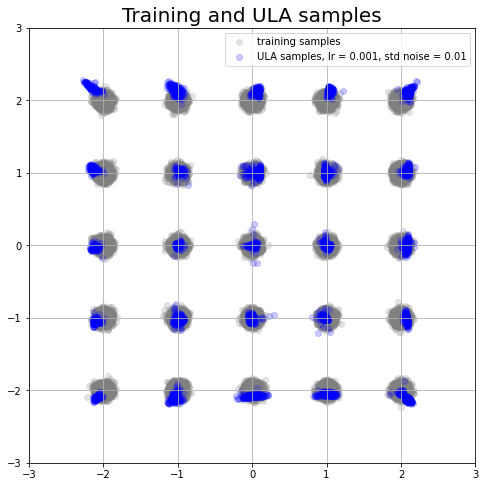

In [13]:
X_langevin = torch.FloatTensor(z_last_np).to(proposal.device)
X_langevin = G(X_langevin).data.cpu().numpy()
mode = 'ULA'
params = f'lr = {grad_step}, std noise = {round(eps_scale, 3)}'
plot_fake_data_mode(X_langevin, X_train, mode, 
                    scaler = scaler,
                    params = params)

100%|██████████| 1/1 [00:00<00:00, 11.55it/s]


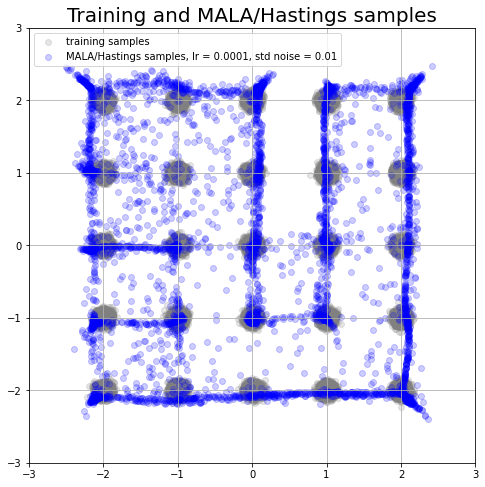

In [140]:
batch_size_sample = 5000
n_steps = 10
grad_step = 1e-4
eps_scale = 1e-2
mala_sampling_plot_2d(target_gan,
                      proposal,
                      X_train,  
                      scaler = scaler, 
                      batch_size_sample = batch_size_sample,
                      grad_step = grad_step,
                      eps_scale = eps_scale,
                      n_steps = n_steps,
                      n_batches = 1,
                      acceptance_rule = 'Hastings',
                      latent_transform = G)

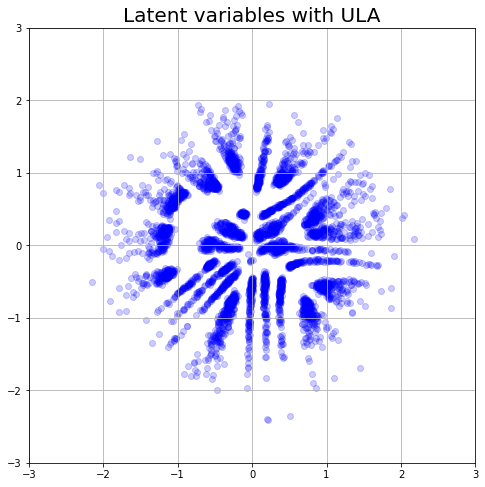

In [16]:
figsize=(8,8)
plt.figure(figsize=figsize)
plt.xlim(-3., 3.)
plt.ylim(-3., 3.)
title = f"Latent variables with ULA"
plt.title(title, fontsize=20)
plt.scatter(z_last_np[:,:1], z_last_np[:,1:], alpha=0.2, color='blue', 
            marker='o', label = 'latent variables')
plt.grid(True)
plt.show()

In [34]:
def grad_energy(point, target, x=None):
    point = point.detach().requires_grad_()
    if x is not None:
        energy = -target(z=point, x=x)
    else:
        energy = -target(point)
    grad = torch.autograd.grad(energy.sum(), point)[0]
    return energy, grad    

In [ ]:
def langevin_dynamics(z, target, proposal, n_steps, grad_step, eps_scale):
    z_sp = []
    batch_size, z_dim = z.shape[0], z.shape[1]

    for _ in range(n_steps):
        z_sp.append(z)
        eps = eps_scale*proposal.sample([batch_size])

        E, grad = grad_energy(z, target, x=None)
        z = z - grad_step * grad + eps        
        z = z.data
        z.requires_grad_(True)
    z_sp.append(z)
    return z_sp

In [359]:
n_steps = 20000
random_seed = 39
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed) 
grad_step = 1e-3
eps_scale = 1e-2
batch_size = 100
z_start = proposal.sample([batch_size])
z_start.requires_grad_(True)
z_sp_langevin = langevin_dynamics(z_start, target_gan, proposal, n_steps, grad_step, eps_scale)
z_sp_stack_langevin = torch.stack(z_sp_langevin, dim = 1).data.cpu().numpy()

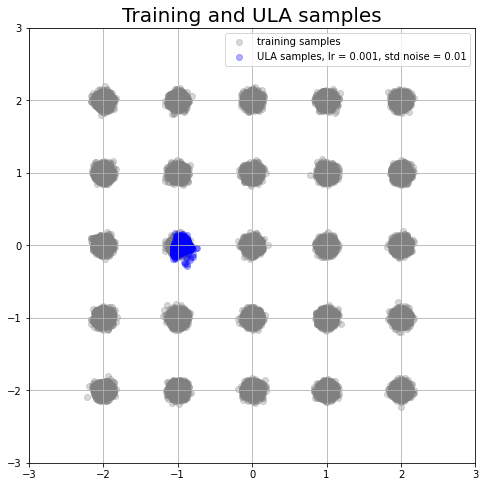

In [360]:
X_langevin = torch.FloatTensor(z_sp_stack_langevin[3, :, :]).to(proposal.device)
X_langevin = X_langevin.view(-1, 2)
X_langevin = G(X_langevin).data.cpu().numpy()
X_langevin = scaler.inverse_transform(X_langevin)
mode = 'ULA'
params = f'lr = {grad_step}, std noise = {round(eps_scale, 3)}'
plot_fake_data_mode(X_langevin, X_train, mode, 
                    params = params)

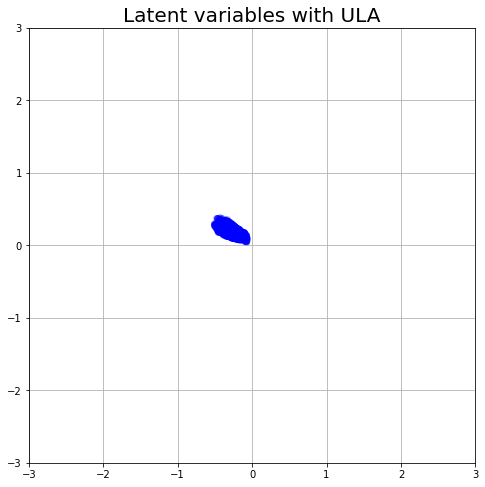

In [361]:
z_last_langevin = z_sp_stack_langevin[3, :, :]
figsize=(8,8)
plt.figure(figsize=figsize)
plt.xlim(-3., 3.)
plt.ylim(-3., 3.)
title = f"Latent variables with ULA"
plt.title(title, fontsize=20)
plt.scatter(z_last_langevin[:,:1], z_last_langevin[:,1:], alpha=0.2, color='blue', 
            marker='o', label = 'latent variables')
plt.grid(True)
plt.show()

In [351]:
z_last_langevin

array([[-0.08308131,  0.06186325],
       [-0.07644448,  0.06179609],
       [-0.08305931,  0.05786598],
       ...,
       [-0.3005763 ,  0.25171822],
       [-0.3068441 ,  0.25976765],
       [-0.31301573,  0.27045518]], dtype=float32)

In [352]:
z_last_mala

array([[-0.08308131,  0.06186325],
       [-0.07644448,  0.06179609],
       [-0.08305931,  0.05786598],
       ...,
       [-0.35448143,  0.30495948],
       [-0.3608452 ,  0.31355453],
       [-0.36731017,  0.3240476 ]], dtype=float32)

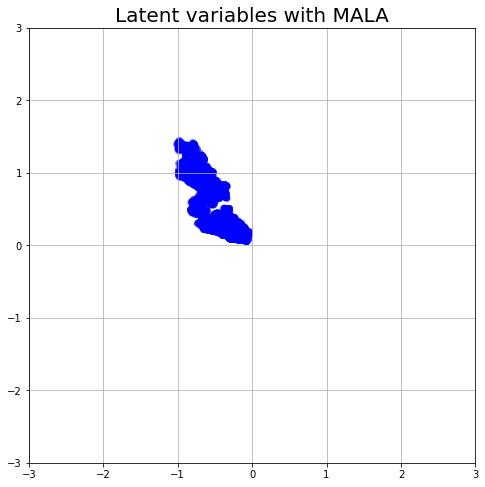

In [363]:
z_last_mala = z_sp_stack_mala[3, :, :]
figsize=(8,8)
plt.figure(figsize=figsize)
plt.xlim(-3., 3.)
plt.ylim(-3., 3.)
title = f"Latent variables with MALA"
plt.title(title, fontsize=20)
plt.scatter(z_last_mala[:,:1], z_last_mala[:,1:], alpha=0.2, color='blue', 
            marker='o', label = 'latent variables')
plt.grid(True)
plt.show()

In [368]:
def mala_dynamics(z, target, proposal, n_steps, grad_step, eps_scale, acceptance_rule='Hastings'):
    z_sp = [z.clone().detach()]
    batch_size, z_dim = z.shape[0], z.shape[1]
    device = z.device

    uniform = Uniform(low = 0.0, high = 1.0)
    acceptence = torch.zeros(batch_size).to(device)

    for _ in range(n_steps):
        #print(f"z = {z}")
        eps = eps_scale * proposal.sample([batch_size])

        E, grad = grad_energy(z, target, x=None)
        
        new_z = z - grad_step * grad + eps
        new_z = new_z.data
        new_z.requires_grad_(True)
        
        E_new, grad_new = grad_energy(new_z, target, x=None)
        
        energy_part = E - E_new
        
        propose_vec_1 = z - new_z + grad_step*grad_new
        propose_vec_2 = new_z - z + grad_step*grad
        
        propose_part_1 = proposal.log_prob(propose_vec_1/eps_scale)
        propose_part_2 = proposal.log_prob(propose_vec_2/eps_scale)
        
        propose_part = propose_part_1 - propose_part_2

        if acceptance_rule == 'Hastings':
            log_accept_prob = propose_part + energy_part

        elif acceptance_rule == 'Barker':
            log_ratio = propose_part + energy_part
            log_accept_prob = -torch.log(1. + torch.exp(-log_ratio))

        generate_uniform_var = uniform.sample([batch_size]).to(z.device)
        log_generate_uniform_var = torch.log(generate_uniform_var)
        mask = log_generate_uniform_var < log_accept_prob
        mask = mask.detach()
        
        acceptence += mask
        with torch.no_grad():
            z[mask] = new_z[mask].detach().clone()
            z = z.data
            z.requires_grad_(True)
            z_sp.append(z.clone().detach())
        
    return z_sp, acceptence

In [369]:
n_steps = 100
random_seed = 39
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed) 
grad_step = 1e-3
eps_scale = 1e-2
batch_size = 100
z_start = proposal.sample([batch_size])
#z_start = z_start[:20, :]
z_start.requires_grad_(True)
z_sp_mala, acceptence = mala_dynamics(z_start, target_gan, proposal, n_steps, grad_step, eps_scale)
z_sp_stack_mala = torch.stack(z_sp_mala, dim = 1).data.cpu().numpy()

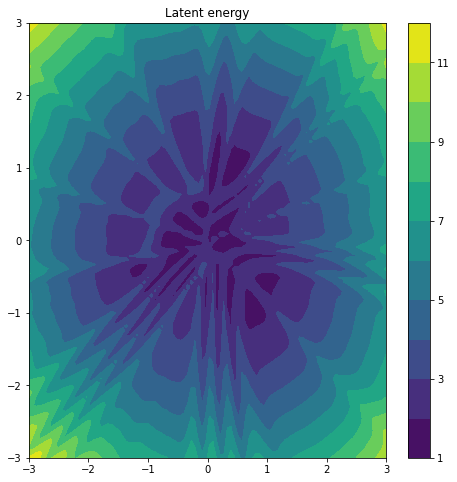

In [17]:
log_prob = False
target_gan_energy = partial(gan_energy, 
                            generator = G, 
                            discriminator = D, 
                            proposal = normal,
                            normalize_to_0_1 = normalize_to_0_1,
                            log_prob = log_prob)
x_range = 3.0
y_range = 3.0
norm_grads = False
plot_potential_energy(target_gan_energy,
                      x_range,
                      y_range,
                      device,
                      norm_grads = norm_grads,
                      num_points = 100)figsize=(8,8)
plt.figure(figsize=figsize)
plt.xlim(-3., 3.)
plt.ylim(-3., 3.)
title = f"Latent variables with ULA"
plt.title(title, fontsize=20)
plt.scatter(z_last_np[:,:1], z_last_np[:,1:], alpha=0.2, color='blue', 
            marker='o', label = 'latent variables')
plt.grid(True)
plt.show()

In [371]:
def mala_dynamics(z, target, proposal, n_steps, grad_step, eps_scale, acceptance_rule='Hastings'):
    z_sp = [z.clone().detach()]
    batch_size, z_dim = z.shape[0], z.shape[1]
    device = z.device

    uniform = Uniform(low = 0.0, high = 1.0)
    acceptence = torch.zeros(batch_size).to(device)

    for _ in range(n_steps):
        #print(f"z = {z}")
        eps = eps_scale * proposal.sample([batch_size])

        E, grad = grad_energy(z, target, x=None)
        
        new_z = z - grad_step * grad + eps
        new_z = new_z.data
        new_z.requires_grad_(True)
        
        E_new, grad_new = grad_energy(new_z, target, x=None)
        
        energy_part = E - E_new
        
        propose_vec_1 = z - new_z + grad_step*grad_new
        propose_vec_2 = new_z - z + grad_step*grad
        
        propose_part_1 = proposal.log_prob(propose_vec_1/eps_scale)
        propose_part_2 = proposal.log_prob(propose_vec_2/eps_scale)
        
        propose_part = propose_part_1 - propose_part_2

        if acceptance_rule == 'Hastings':
            log_accept_prob = propose_part + energy_part

        elif acceptance_rule == 'Barker':
            log_ratio = propose_part + energy_part
            log_accept_prob = -torch.log(1. + torch.exp(-log_ratio))

        generate_uniform_var = uniform.sample([batch_size]).to(z.device)
        log_generate_uniform_var = torch.log(generate_uniform_var)
        mask = log_generate_uniform_var < log_accept_prob
        mask = mask.detach()
        
        acceptence += mask
        with torch.no_grad():
            z[mask] = new_z[mask].detach().clone()
            z = z.data
            z.requires_grad_(True)
            z_sp.append(z.clone().detach())
        
    return z_sp, acceptence

In [390]:
n_steps = 500
random_seed = 540
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed) 
grad_step = 1e-3
eps_scale = 1e-2
batch_size = 1
z_start = proposal.sample([batch_size])
#z_start = z_start[:20, :]
z_start.requires_grad_(True)
z_sp_mala, acceptence = mala_dynamics(z_start, target_gan, proposal, n_steps, grad_step, eps_scale)
z_sp_stack_mala = torch.stack(z_sp_mala, dim = 1).data.cpu().numpy()

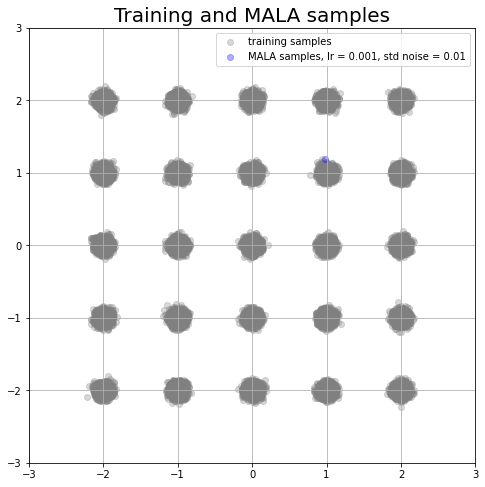

In [391]:
X_mala = torch.FloatTensor(z_sp_stack_mala[:, -1, :]).to(proposal.device)
X_mala = X_mala.view(-1, 2)
X_mala = G(X_mala).data.cpu().numpy()
X_mala = scaler.inverse_transform(X_mala)
mode = 'MALA'
params = f'lr = {grad_step}, std noise = {round(eps_scale, 3)}'
plot_fake_data_mode(X_mala, X_train, mode, 
                    params = params)

In [ ]:
z_last_np = z_sp_stack_langevin[3, :, :]
figsize=(8,8)
plt.figure(figsize=figsize)
plt.xlim(-3., 3.)
plt.ylim(-3., 3.)
title = f"Latent variables with ULA"
plt.title(title, fontsize=20)
plt.scatter(z_last_np[:,:1], z_last_np[:,1:], alpha=0.2, color='blue', 
            marker='o', label = 'latent variables')
plt.grid(True)
plt.show()

In [292]:
z_sp_stack_mala[:20, :, :]

array([[[-1.0142456e-02,  2.6478651e-01],
        [-2.1191508e-02,  2.6993567e-01],
        [-2.1191508e-02,  2.6993567e-01],
        [-3.4298129e-02,  2.6414594e-01],
        [-3.4298129e-02,  2.6414594e-01],
        [-3.9702497e-02,  2.7016008e-01],
        [-3.9702497e-02,  2.7016008e-01],
        [-3.9702497e-02,  2.7016008e-01],
        [-5.1026862e-02,  2.6683903e-01],
        [-5.3666484e-02,  2.7149415e-01],
        [-5.3666484e-02,  2.7149415e-01]],

       [[ 2.5774038e-01, -5.3212887e-01],
        [ 2.5774038e-01, -5.3212887e-01],
        [ 2.6367882e-01, -5.4581368e-01],
        [ 2.5691009e-01, -5.4652154e-01],
        [ 2.5691009e-01, -5.4652154e-01],
        [ 2.5691009e-01, -5.4652154e-01],
        [ 2.5691009e-01, -5.4652154e-01],
        [ 2.5691009e-01, -5.4652154e-01],
        [ 2.5691009e-01, -5.4652154e-01],
        [ 2.5561437e-01, -5.4772460e-01],
        [ 2.5561437e-01, -5.4772460e-01]],

       [[-2.3708689e-01, -3.2693443e-01],
        [-2.3708689e-01, -3.26

In [290]:
z_sp_stack_langevin[:20, :, :]

array([[[-1.01424558e-02,  2.64786512e-01],
        [-2.11915076e-02,  2.69935668e-01],
        [-1.73335783e-02,  2.80847520e-01],
        [-2.90425085e-02,  2.79508293e-01],
        [-5.38787469e-02,  2.96195924e-01],
        [-5.92969432e-02,  3.11719000e-01],
        [-6.76481798e-02,  3.34258586e-01],
        [-6.51886165e-02,  3.46718609e-01],
        [-7.68539682e-02,  3.46438825e-01],
        [-7.88845941e-02,  3.53863388e-01],
        [-6.97598681e-02,  3.65783006e-01]],

       [[ 2.57740378e-01, -5.32128870e-01],
        [ 2.46946350e-01, -5.33679962e-01],
        [ 2.36201406e-01, -5.46303213e-01],
        [ 2.06396893e-01, -5.45646429e-01],
        [ 1.94265381e-01, -5.57737291e-01],
        [ 1.58761203e-01, -5.45342028e-01],
        [ 1.69502765e-01, -5.33473194e-01],
        [ 1.51573375e-01, -5.18958271e-01],
        [ 1.70725062e-01, -5.18357337e-01],
        [ 1.58763111e-01, -5.18856943e-01],
        [ 1.66328251e-01, -5.39887071e-01]],

       [[-2.37086892e-01, -3

In [319]:
n_steps = 10000
random_seed = 39
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed) 
grad_step = 1e-3
eps_scale = 1e-2
batch_size = 100
z_start = proposal.sample([batch_size])
z_start = z_start[:20, :]
z_start.requires_grad_(True)
z_sp_mala, acceptence = mala_dynamics(z_start, target_gan, proposal, n_steps, grad_step, eps_scale)
z_sp_stack_mala = torch.stack(z_sp_mala, dim = 1).data.cpu().numpy()

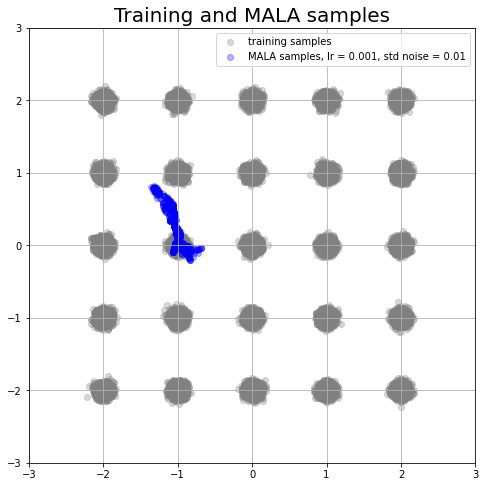

In [335]:
X_mala = torch.FloatTensor(z_sp_stack_mala[3, :1000, :]).to(proposal.device)
X_mala = X_mala.view(-1, 2)
X_mala = G(X_mala).data.cpu().numpy()
X_mala = scaler.inverse_transform(X_mala)
mode = 'MALA'
params = f'lr = {grad_step}, std noise = {round(eps_scale, 3)}'
plot_fake_data_mode(X_mala, X_train, mode, 
                    params = params)

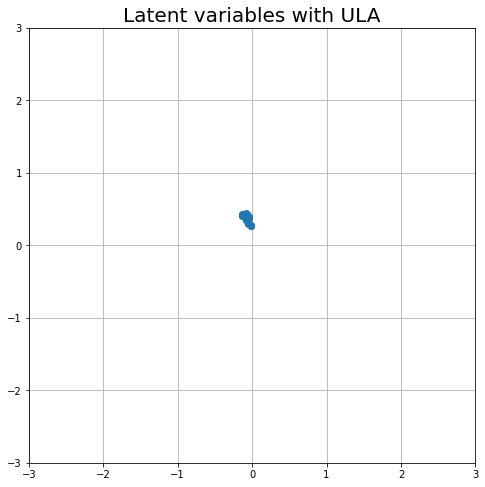

In [104]:
figsize=(8,8)
plt.figure(figsize=figsize)
plt.xlim(-3., 3.)
plt.ylim(-3., 3.)
title = f"Latent variables with ULA"
plt.title(title, fontsize=20)
for i in range(z_sp_stack.shape[0]):
    x_arr = z_sp_stack[i, :, 0]
    y_arr = z_sp_stack[i, :, 1]
    u = np.diff(x_arr)
    v = np.diff(y_arr)
    pos_q = x_arr[:-1] + u/2
    pos_p = y_arr[:-1] + v/2
    norm = np.sqrt(u**2+v**2) 

    plt.plot(x_arr, y_arr, label = 'dynamics', marker="o")
    #plt.quiver(pos_q, pos_p, u/norm, v/norm, angles="xy", zorder=5, pivot="mid")
plt.grid(True)
plt.show()

In [132]:
X_langevin

array([[-0.5301272 ,  0.51841015],
       [-0.5744652 ,  0.5321163 ],
       [-0.5424822 ,  0.56663346],
       [-0.57724094,  0.5137067 ],
       [-0.6813372 ,  0.5651117 ],
       [-0.6983066 ,  0.5849605 ],
       [-0.727665  ,  0.6478316 ],
       [-0.71873116,  0.6877306 ],
       [-0.7459915 ,  0.66574794],
       [-0.75190943,  0.6769044 ],
       [-0.7240083 ,  0.7104508 ],
       [-0.6249912 ,  0.66919094],
       [-0.6687253 ,  0.6802165 ],
       [-0.6159136 ,  0.6769053 ],
       [-0.59281284,  0.6764144 ],
       [-0.6291041 ,  0.69984937],
       [-0.5875745 ,  0.7404256 ],
       [-0.51945657,  0.70983845],
       [-0.5194294 ,  0.67935765],
       [-0.47174904,  0.6666987 ],
       [-0.41209987,  0.6718856 ],
       [-0.3956372 ,  0.66331226],
       [-0.36509883,  0.6664545 ],
       [-0.29312462,  0.6410679 ],
       [-0.3223442 ,  0.6683788 ],
       [-0.24857067,  0.6741618 ],
       [-0.28498283,  0.59896284],
       [-0.16353486,  0.5560391 ],
       [-0.12363214,

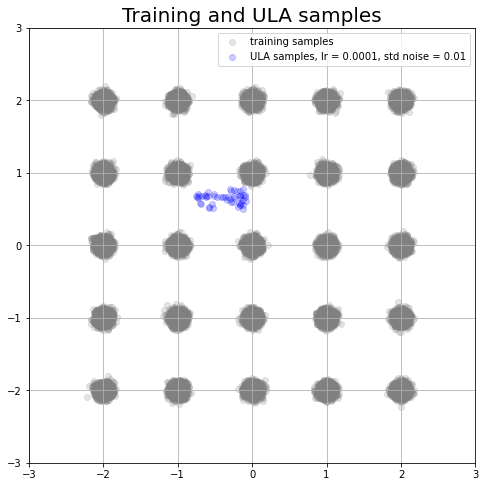

In [131]:
X_langevin = torch.FloatTensor(z_sp_stack_langevin).to(proposal.device)
X_langevin = X_langevin.view(-1, 2)
X_langevin = G(X_langevin).data.cpu().numpy()
X_langevin = scaler.inverse_transform(X_langevin)
mode = 'ULA'
params = f'lr = {grad_step}, std noise = {round(eps_scale, 3)}'
plot_fake_data_mode(X_langevin, X_train, mode, 
                    params = params)

In [274]:
n_steps = 200
random_seed = 39
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed) 
grad_step = 1e-5
eps_scale = 1e-4
batch_size = 100
z_start = proposal.sample([batch_size])
z_start = z_start[:20, :]
z_start.requires_grad_(True)
z_sp_mala, acceptence = mala_dynamics(z_start, target_gan, proposal, n_steps, grad_step, eps_scale)
z_sp_stack_mala = torch.stack(z_sp_mala, dim = 1).data.cpu().numpy()

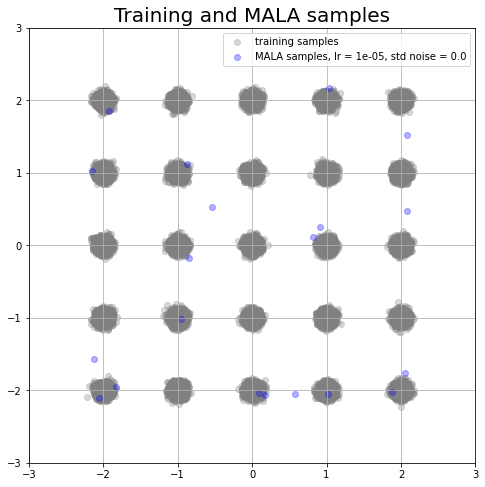

In [275]:
X_mala = torch.FloatTensor(z_sp_stack_mala[:20, -1, :]).to(proposal.device)
X_mala = X_mala.view(-1, 2)
X_mala = G(X_mala).data.cpu().numpy()
X_mala = scaler.inverse_transform(X_mala)
mode = 'MALA'
params = f'lr = {grad_step}, std noise = {round(eps_scale, 3)}'
plot_fake_data_mode(X_mala, X_train, mode, 
                    params = params)

In [199]:
X_mala

array([[-0.4546006 ,  0.64851266]], dtype=float32)

In [61]:
def mala_dynamics(z, target, proposal, n_steps, grad_step, eps_scale, acceptance_rule='hastings'):
    z_sp = [z.clone().detach()]
    batch_size, z_dim = z.shape[0], z.shape[1]
    device = z.device

    uniform = Uniform(low = 0.0, high = 1.0)
    acceptence = torch.zeros(batch_size).to(device)

    for _ in range(n_steps):
        eps = eps_scale * proposal.sample([batch_size])

        E, grad = grad_energy(z, target, x=None)
        
        new_z = z - grad_step * grad + eps
        new_z = new_z.data
        new_z.requires_grad_(True)
        
        E_new, grad_new = grad_energy(new_z, target, x=None)
        
        energy_part = E - E_new
        
        propose_vec_1 = z - new_z + grad_step*grad_new
        propose_vec_2 = new_z - z + grad_step*grad
        
        propose_part_1 = proposal.log_prob(propose_vec_1/eps_scale)
        propose_part_2 = proposal.log_prob(propose_vec_2/eps_scale)
        
        propose_part = propose_part_1 - propose_part_2
        
        log_accept_prob = propose_part + energy_part
        if acceptance_rule == 'Hastings':
            log_accept_prob = propose_part + energy_part

        elif acceptance_rule == 'Barker':
            log_ratio = propose_part + energy_part
            log_accept_prob = -torch.log(1. + torch.exp(-log_ratio))

        generate_uniform_var = uniform.sample([batch_size]).to(z.device)
        log_generate_uniform_var = torch.log(generate_uniform_var)
        mask = log_generate_uniform_var < log_accept_prob
        
        acceptence += mask
        with torch.no_grad():
            z[mask] = new_z[mask].detach().clone()
            z = z.data
            z.requires_grad_(True)
            z_sp.append(z.clone().detach())
        
    return z_sp, acceptence

In [65]:
n_steps = 10
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed) 
batch_size = 5
z = proposal.sample([batch_size])
z.requires_grad_(True)
z_sp, acceptence = mala_dynamics(z, target_gan, proposal, n_steps, grad_step, eps_scale)
last = z_sp[-1].data.cpu().numpy()

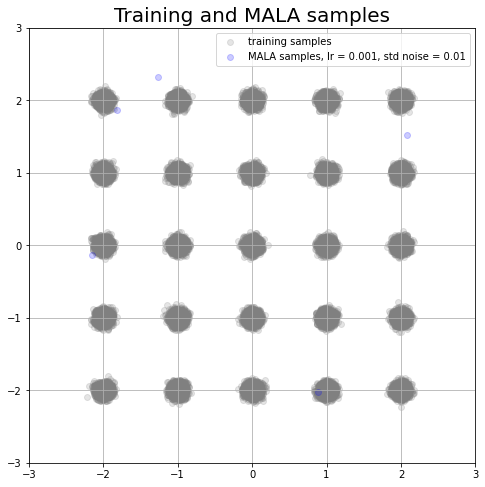

In [67]:
X_mala = torch.FloatTensor(last).to(proposal.device)
X_mala = G(X_mala).data.cpu().numpy()
mode = 'MALA'
params = f'lr = {grad_step}, std noise = {round(eps_scale, 3)}'
plot_fake_data_mode(X_mala, X_train, mode, 
                    scaler = scaler,
                    params = params)

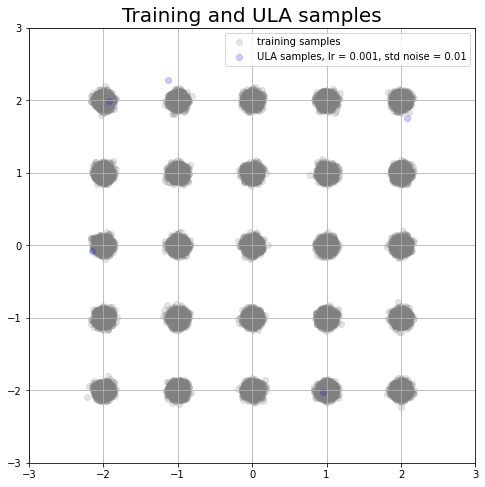

In [56]:
X_langevin = torch.FloatTensor(last).to(proposal.device)
X_langevin = G(X_langevin).data.cpu().numpy()
mode = 'ULA'
params = f'lr = {grad_step}, std noise = {round(eps_scale, 3)}'
plot_fake_data_mode(X_langevin, X_train, mode, 
                    scaler = scaler,
                    params = params)

In [18]:
batch_size_sample = 5000
n_steps = 500
grad_step = 1e-3
eps_scale = 1e-2
z_last_np, zs = mala_sampling(target_gan,
                              proposal,  
                              batch_size=batch_size_sample,
                              n = batch_size_sample,
                              grad_step = grad_step,
                              eps_scale = eps_scale,
                              n_steps = n_steps)

100%|██████████| 1/1 [00:04<00:00,  4.29s/it]


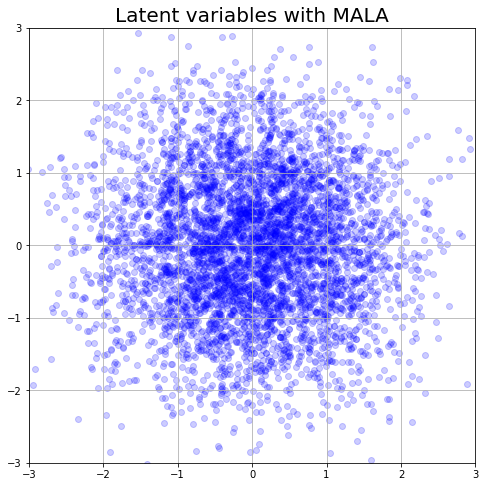

In [19]:
figsize=(8,8)
plt.figure(figsize=figsize)
plt.xlim(-3., 3.)
plt.ylim(-3., 3.)
title = f"Latent variables with MALA"
plt.title(title, fontsize=20)
plt.scatter(z_last_np[:,:1], z_last_np[:,1:], alpha=0.2, color='blue', 
            marker='o', label = 'latent variables')
plt.grid(True)
plt.show()

In [422]:
def mala_dynamics_slow(z, target, proposal, n_steps, grad_step, eps_scale, acceptance_rule='Hastings'):
    z_sp = [z.clone().detach()]
    z_dim = z.shape[1]
    device = z.device

    uniform = Uniform(low = 0.0, high = 1.0)
    acceptence = torch.zeros(1).to(device)
    

    for _ in range(n_steps):
        print(f"z = {z}")      
        eps = eps_scale * proposal.sample([1])
        
        #print(z)

        E, grad = grad_energy(z, target, x=None)
        print(f"energy in z = {E}")
        
        new_z = z - grad_step * grad + eps
        new_z = new_z.data
        new_z.requires_grad_(True)
        
        E_new, grad_new = grad_energy(new_z, target, x=None)
        print(f"new_energy = {E_new}")
        
        energy_part = E - E_new
        
        #print(energy_part)
        
        propose_vec_1 = z - new_z + grad_step*grad_new
        propose_vec_2 = new_z - z + grad_step*grad
        
        propose_part_1 = proposal.log_prob(propose_vec_1/eps_scale)
        propose_part_2 = proposal.log_prob(propose_vec_2/eps_scale)
        
        propose_part = propose_part_1 - propose_part_2

        if acceptance_rule == 'Hastings':
            log_accept_prob = propose_part + energy_part

        elif acceptance_rule == 'Barker':
            log_ratio = propose_part + energy_part
            log_accept_prob = -torch.log(1. + torch.exp(-log_ratio))

        #print(log_accept_prob)
        generate_uniform_var = uniform.sample([1]).to(z.device)
        log_generate_uniform_var = torch.log(generate_uniform_var)
        mask = log_generate_uniform_var < log_accept_prob
        mask = mask.detach()
        print(mask)
        
        acceptence += mask
        with torch.no_grad():
            z[mask] = new_z[mask].detach().clone()
            z = z.data
            z.requires_grad_(True)
            z_sp.append(z.clone().detach())
        
    return z_sp

In [423]:
random_seed = 39
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed) 
grad_step = 1e-3
eps_scale = 1e-2
n_steps = 10
result = []
batch_size = 1
for i in tqdm(range(batch_size)):
    z_start = proposal.sample([1])
    z_start.requires_grad_(True)
    res = mala_dynamics_slow(z_start, target_gan, proposal, n_steps, grad_step, eps_scale)
    last = res[-1]
    result.append(last)

100%|██████████| 1/1 [00:00<00:00, 10.63it/s]

z = tensor([[-0.0101,  0.2648]], device='cuda:0', requires_grad=True)
energy in z = tensor([2.4033], device='cuda:0', grad_fn=<NegBackward>)
new_energy = tensor([2.3556], device='cuda:0', grad_fn=<NegBackward>)
tensor([True], device='cuda:0')
z = tensor([[-0.0212,  0.2699]], device='cuda:0', requires_grad=True)
energy in z = tensor([2.3556], device='cuda:0', grad_fn=<NegBackward>)
new_energy = tensor([2.2893], device='cuda:0', grad_fn=<NegBackward>)
tensor([False], device='cuda:0')
z = tensor([[-0.0212,  0.2699]], device='cuda:0', requires_grad=True)
energy in z = tensor([2.3556], device='cuda:0', grad_fn=<NegBackward>)
new_energy = tensor([2.3337], device='cuda:0', grad_fn=<NegBackward>)
tensor([True], device='cuda:0')
z = tensor([[-0.0343,  0.2641]], device='cuda:0', requires_grad=True)
energy in z = tensor([2.3337], device='cuda:0', grad_fn=<NegBackward>)
new_energy = tensor([2.2231], device='cuda:0', grad_fn=<NegBackward>)
tensor([False], device='cuda:0')
z = tensor([[-0.0343,  0.2

In [415]:
lat_arr = torch.stack(result, dim = 0)

In [417]:
lat_arr = lat_arr.squeeze()

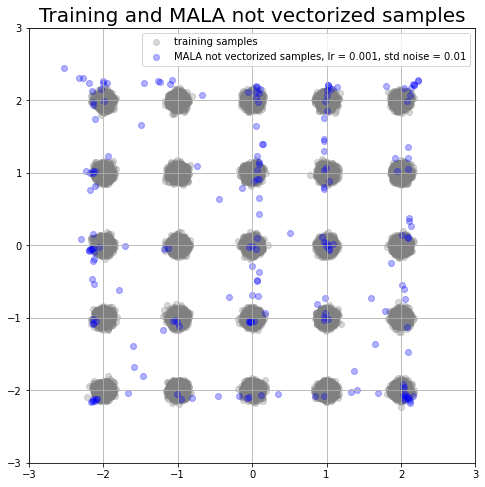

In [419]:
X_mala_slow = G(lat_arr).data.cpu().numpy()
mode = 'MALA not vectorized'
params = f'lr = {grad_step}, std noise = {round(eps_scale, 3)}'
plot_fake_data_mode(X_mala_slow, X_train, mode, 
                    scaler = scaler,
                    params = params)